In [1]:

from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import torch

from CustomDataset import CustomDataset
from EarlyStopper import EarlyStopper
from models import CustomModel
from train import kfold_train_eval

df = pd.read_csv('data/OnionOrNot.csv')
df

,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,1
1,Muslim Woman Denied Soda Can for Fear She Coul...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,1
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1
4,"For men looking for great single women, online...",1
...,...,...
23995,Teen Pregnancy Rate Prompting More High School...,1
23996,Connecticut TV station under fire after using ...,0
23997,Jurisprudence Fetishist Gets Off On Technicality,1
23998,Employees From Other Department Announce Plan ...,1


In [2]:
n_positive = sum(df['label'] == 1)
n_negative = sum(df['label'] == 0)

print(f"{len(df):,} rows: {n_positive:,} positive, {n_negative:,} negative")

24,000 rows: 9,000 positive, 15,000 negative


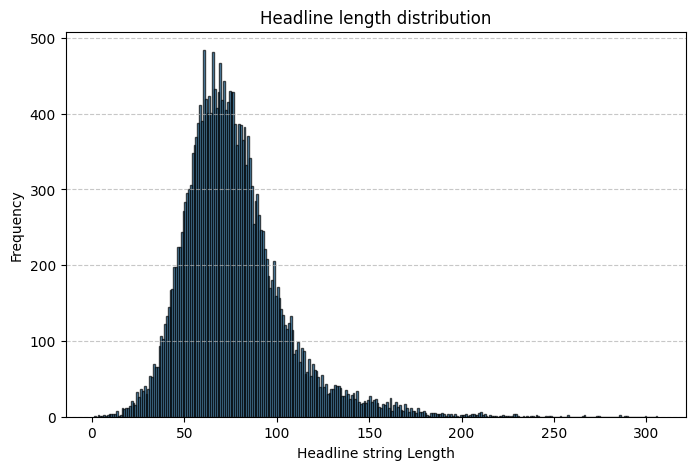

Shortest headline: 1 character(s)
Longest headline: 305 character(s)


In [3]:
text_length = df['text'].str.len()
# Plot histogram
plt.figure(figsize=(8, 5))
min_text_length = int(text_length.min())
max_text_length = int(text_length.max())
plt.hist(text_length, bins=range(min_text_length, max_text_length + 2), edgecolor='black', alpha=0.7)
plt.xlabel('Headline string Length')
plt.ylabel('Frequency')
plt.title('Headline length distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Shortest headline: {min_text_length} character(s)")
print(f"Longest headline: {max_text_length} character(s)")


In [4]:
max_sequence_length = 1 if max_text_length <= 0 else 2 ** (max_text_length - 1).bit_length()
print(f"Using {max_sequence_length:,} as max sequence length")

dataset = CustomDataset("data/OnionOrNot.csv", max_sequence_length=max_sequence_length)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Using 512 as max sequence length
Device: cuda:0


In [5]:
batch_size = 256
model = CustomModel(vocab_size=dataset.tokenizer.get_vocab_size(), context_length=max_sequence_length, focal_alpha=0.5,
                    focal_gamma=2.5,
                    dropout=0.25, hidden_layers=3, attention_layers=1, expand=4, embed_dim=512, n_heads=8)
print(model)


CustomModel(
  (token_embedding): Embedding(30000, 512)
  (position_embedding): Embedding(512, 512)
  (model): Sequential(
    (0): AttentionLayer(
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
    )
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (linear): MLPBinaryClassifier(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=2048, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=2048, out_features=2048, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.25, inplace=False)
      (6): Linear(in_features=2048, out_features=2048, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.25, inplace=False)
      (9): Linear(in_features=2048, out_features=1, bias=True)
      (10): Sigmoid()
    )
  )
)


In [6]:
print(f"Training starts {datetime.now().isoformat()}")


Training starts 2025-02-14T22:39:19.393904


In [7]:

model = model.to(device)

metrics = kfold_train_eval(model, dataset, device, k=5, batch_size=batch_size, learning_rate=0.0001, max_epochs=5 )

Fold 0: 100%|██████████| 5/5 [01:04<00:00, 12.88s/it]


Fold 0, epochs 5: loss:0.038398, accuracy:0.807083, precision:0.767770, recall:0.696111, f1:0.730186, mcc:0.582304, pr_auc:0.882109


Fold 1: 100%|██████████| 5/5 [01:04<00:00, 12.91s/it]


Fold 1, epochs 5: loss:0.033383, accuracy:0.844375, precision:0.813206, recall:0.759444, f1:0.785406, mcc:0.664507, pr_auc:0.917177


Fold 2: 100%|██████████| 5/5 [01:04<00:00, 12.89s/it]


Fold 2, epochs 5: loss:0.030881, accuracy:0.867083, precision:0.810363, recall:0.842778, f1:0.826253, mcc:0.719057, pr_auc:0.938745


Fold 3: 100%|██████████| 5/5 [01:04<00:00, 12.91s/it]


Fold 3, epochs 5: loss:0.023697, accuracy:0.901458, precision:0.863961, recall:0.875000, f1:0.869445, mcc:0.790355, pr_auc:0.961787


Fold 4: 100%|██████████| 5/5 [01:04<00:00, 12.91s/it]


Fold 4, epochs 5: loss:0.020622, accuracy:0.918750, precision:0.881907, recall:0.904444, f1:0.893033, mcc:0.827719, pr_auc:0.973481


In [8]:
print(f"Training ends {datetime.now().isoformat()}")

Training ends 2025-02-14T22:44:49.264646


In [9]:
for metric in metrics:
    print(f"{metric}:", metrics[metric])

test_loss: 0.029396023679720728
test_accuracy: 0.86775
test_precision: 0.8274413221370001
test_recall: 0.8155555555555555
test_f1: 0.8208648736727469
test_mcc: 0.7167883718582126
test_pr_auc: 0.9346598703703703
